<a href="https://colab.research.google.com/github/louisgraham333/cancer_image_detection_kaggle/blob/main/Image_Classification_Script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Histopathologic Cancer Detection
*This notebook is created for the Kaggle Histopathologic Cancer Detection Challenge. It pulls the data from Kaggle, analyses it, and creates a set of estimates for the validation set*

---



## Chapters


1. Prepare the script and pull data from Kaggle
2. Download the data, and move to correct folders
3. Create and fit the model (Keras-Tensorflow)
4. Predict on the validation set

## Chapter 1: Prepare the script
Import packages, set up the file directory, and set up the link to Kaggle

In [ ]:
###Install and import packages
!pip install kaggle
!pip install -U -q kaggle
import json
import zipfile
import os
import pandas as pd
import numpy as np
from glob import glob
import time
import shutil
import skimage.io as io
from skimage.io import imread
import matplotlib.pyplot as plt
import random
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow import set_random_seed

    100% |████████████████████████████████| 993kB 18.9MB/s 


In [ ]:
#Authenticate Google Drive (to allow saving)
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()                       
drive = GoogleDrive(gauth)

In [ ]:
#Set seed object
seed_object = np.random.seed(7654)
random.seed(seed_object)
set_random_seed(101)

In [ ]:
#Create directory structure for image generator to work off
base_dir = 'base_dir'
os.mkdir(base_dir)
train_all_dir = os.path.join(base_dir, 'train_all_dir')
os.mkdir(train_all_dir)
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)
no_tumor_tissue = os.path.join(train_dir, 'a_no_tumor_tissue')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(train_dir, 'b_has_tumor_tissue')
os.mkdir(has_tumor_tissue)
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)
no_tumor_tissue = os.path.join(val_dir, 'a_no_tumor_tissue')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(val_dir, 'b_has_tumor_tissue')
os.mkdir(has_tumor_tissue)
test_dir = os.path.join(base_dir, 'test_dir')
os.mkdir(test_dir)
test_images = os.path.join(test_dir, 'test_images')
os.mkdir(test_images)

In [ ]:
###Set up connection to Kaggle and upload API file
!mkdir -p ~/.kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"louisgraham","key":"07832db7ffde0bd6a22415c90dd32b17"}'}

In [ ]:
###Store API file, make private and view API
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions list   

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       2468           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge       9993            True  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge       4052            True  
imagenet-object-localization-challenge         2029-12-31 07:00:00  Research         Knowledge         35           False  
competitive-data-science-predict-future-sales  2019-12-31 23:59:00  Playground           Kudos       2452           False  
two-sigma-financial-news                       2019-07-15 23:59:00  Featured          $100,000       2927           False  
LANL-Ear

In [ ]:
###Listfiles in the competition
!kaggle competitions files histopathologic-cancer-detection

name                   size  creationDate         
---------------------  ----  -------------------  
sample_submission.csv   2MB  2018-11-15 23:20:36  
train_labels.csv        9MB  2018-11-15 23:20:37  
test.zip                1GB  2018-11-15 23:21:06  
train.zip               5GB  2018-11-15 23:23:49  


##Chapter 2: Download the data, and move to correct folders
Pull the data from the Kaggle API to colab, and then shift into the correct folders for the data generator to work off

In [ ]:
###Download sample submission, unzip and delete zip
os.chdir('/content/base_dir')
!kaggle competitions download -f sample_submission.csv histopathologic-cancer-detection
!unzip -q sample_submission.csv
os.remove("sample_submission.csv.zip")

  0% 0.00/1.33M [00:00<?, ?B/s]
100% 1.33M/1.33M [00:00<00:00, 43.3MB/s]


In [ ]:
###Download train labels, unzip and delete zip
!kaggle competitions download -f train_labels.csv histopathologic-cancer-detection
!unzip -q train_labels.csv
os.remove("train_labels.csv.zip")

 98% 5.00M/5.10M [00:00<00:00, 49.6MB/s]
100% 5.10M/5.10M [00:00<00:00, 46.8MB/s]


In [ ]:
###Download train, unzip and delete zip
os.chdir('/content/base_dir/train_all_dir')
!kaggle competitions download -f train.zip histopathologic-cancer-detection
!unzip -q train
os.remove("train.zip")

100% 4.98G/4.98G [00:44<00:00, 134MB/s]
100% 4.98G/4.98G [00:44<00:00, 121MB/s]


In [ ]:
###Download test, unzip and delete zip
os.chdir('/content/base_dir/test_dir/test_images')
!kaggle competitions download -f test.zip histopathologic-cancer-detection
!unzip -q test
os.remove("test.zip")

100% 1.30G/1.30G [00:09<00:00, 163MB/s]
100% 1.30G/1.30G [00:09<00:00, 142MB/s]


In [ ]:
#Check number of objects in each
print(sum([len(files) for r, d, files in os.walk("/content/base_dir/train_all_dir")]))
print(sum([len(files) for r, d, files in os.walk("/content/base_dir/test_dir")]))

220025
57458


In [ ]:
#Open and inspect labels
os.chdir('/content/base_dir')
labels = pd.read_csv("train_labels.csv")
labels.head(10)

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
5,acfe80838488fae3c89bd21ade75be5c34e66be7,0
6,a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da,1
7,7f6ccae485af121e0b6ee733022e226ee6b0c65f,1
8,559e55a64c9ba828f700e948f6886f4cea919261,0
9,8eaaa7a400aa79d36c2440a4aa101cc14256cda4,0


In [ ]:
#Split labels into train and validation
msk = np.random.rand(len(labels)) < 0.9
train_labels = labels[msk]
val_labels = labels[~msk]

In [ ]:
#Split labels into has tumor and no tumor
train_has_labels = train_labels['id'].loc[train_labels['label'] == 1]
train_no_labels = train_labels['id'].loc[train_labels['label'] == 0]
val_has_labels = val_labels['id'].loc[val_labels['label'] == 1]
val_no_labels = val_labels['id'].loc[val_labels['label'] == 0]

In [ ]:
#Shift train with labels to correct directory
for i in train_has_labels:
  shutil.copyfile("train_all_dir/" + str(i) + ".tif", "train_dir/b_has_tumor_tissue/" + str(i) + ".tif")

In [ ]:
#Shift train without labels to correct directory
for i in train_no_labels:
  shutil.copyfile("train_all_dir/" + str(i) + ".tif", "train_dir/a_no_tumor_tissue/" + str(i) + ".tif")

In [ ]:
#Shift val with labels to correct directory
for i in val_has_labels:
  shutil.copyfile("train_all_dir/" + str(i) + ".tif", "val_dir/b_has_tumor_tissue/" + str(i) + ".tif")

In [ ]:
#Shift val without labels to correct directory
for i in val_no_labels:
  shutil.copyfile("train_all_dir/" + str(i) + ".tif", "val_dir/a_no_tumor_tissue/" + str(i) + ".tif")

In [ ]:
#Check numbers to make sure that they add up
print("All train: " + str(sum([len(files) for r, d, files in os.walk("/content/base_dir/train_all_dir")])))
print("Train no tumour: " + str(sum([len(files) for r, d, files in os.walk("/content/base_dir/train_dir/a_no_tumor_tissue")])))
print("Train with tumour: " + str(sum([len(files) for r, d, files in os.walk("/content/base_dir/train_dir/b_has_tumor_tissue")])))
print("Val no tumour: " + str(sum([len(files) for r, d, files in os.walk("/content/base_dir/val_dir/a_no_tumor_tissue/")])))
print("Val with tumour: " + str(sum([len(files) for r, d, files in os.walk("/content/base_dir/val_dir/b_has_tumor_tissue")])))

All train: 220025
Train no tumour: 117916
Train with tumour: 80356
Val no tumour: 12992
Val with tumour: 8761


##Chapter 3: Create and fit the model
The model is created using Keras, and the inbuilt data generation functions (as not all data can be held in memory)

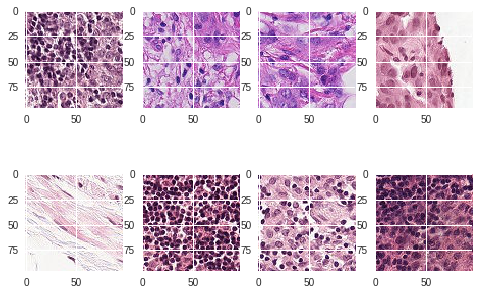

In [ ]:
#Inspect images
f, axarr = plt.subplots(2,4)
axarr[0,0].imshow(io.imread("train_dir/b_has_tumor_tissue/" + str(train_has_labels.iloc[random.randint(1,71429)])+".tif"))
axarr[0,1].imshow(io.imread("train_dir/b_has_tumor_tissue/" + str(train_has_labels.iloc[random.randint(1,71429)])+".tif"))
axarr[0,2].imshow(io.imread("train_dir/b_has_tumor_tissue/" + str(train_has_labels.iloc[random.randint(1,71429)])+".tif"))
axarr[0,3].imshow(io.imread("train_dir/b_has_tumor_tissue/" + str(train_has_labels.iloc[random.randint(1,71429)])+".tif"))
axarr[1,0].imshow(io.imread("train_dir/a_no_tumor_tissue/" + str(train_no_labels.iloc[random.randint(1,104722)])+".tif"))
axarr[1,1].imshow(io.imread("train_dir/a_no_tumor_tissue/" + str(train_no_labels.iloc[random.randint(1,104722)])+".tif"))
axarr[1,2].imshow(io.imread("train_dir/a_no_tumor_tissue/" + str(train_no_labels.iloc[random.randint(1,104722)])+".tif"))
axarr[1,3].imshow(io.imread("train_dir/a_no_tumor_tissue/" + str(train_no_labels.iloc[random.randint(1,104722)])+".tif"))

In [ ]:
#Variables needed for data generators
train_path = "train_dir"
val_path = "val_dir"
image_size = 96
train_batch_size = 32
train_length = sum([len(files) for r, d, files in os.walk("/content/base_dir/train_dir/a_no_tumor_tissue")]) + sum([len(files) for r, d, files in os.walk("/content/base_dir/train_dir/b_has_tumor_tissue")])
train_steps = np.ceil(train_length / train_batch_size)
val_batch_size = 1024
val_length = sum([len(files) for r, d, files in os.walk("/content/base_dir/val_dir/a_no_tumor_tissue")]) + sum([len(files) for r, d, files in os.walk("/content/base_dir/val_dir/b_has_tumor_tissue")])
val_steps = np.ceil(val_length / val_batch_size)

In [ ]:
#Set up the data generators
os.chdir('/content/base_dir')
datagen_train = ImageDataGenerator(rescale=1.0/255)
datagen_val = ImageDataGenerator(rescale=1.0/255)
train_gen = datagen_train.flow_from_directory(train_path,
                                        target_size=(image_size,image_size),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')
val_gen = datagen_val.flow_from_directory(val_path,
                                        target_size=(image_size,image_size),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

Found 198272 images belonging to 2 classes.
Found 21753 images belonging to 2 classes.


In [ ]:
#Set up the model (3 conv layers, then fully connected)
kernel_size = (3,3)
pool_size = (2,2)
first_filters = 32
second_filters = 64
third_filters = 128
dropout = 0.3

model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu',  input_shape = (96, 96, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout))

model.add(Conv2D(second_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(second_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(second_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout))

model.add(Conv2D(third_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(third_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(third_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout))
model.add(Dense(2, activation = "softmax"))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 92, 92, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 90, 90, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 45, 45, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)    

In [ ]:
#Compile the model
model.compile(Adam(lr=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])

In [ ]:
#Save files, and allow the learning rate to adjust if results plateau
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
callbacks_list = [checkpoint, reduce_lr]

In [ ]:
#Get IDs of the files in the folder
file_list = drive.ListFile({'q': "'1jplSxJOM7qGPlGjt0gw_WgQrN7QJQhq_' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: Base_Model_end_32_5.h5, id: 1ctcFJi_zmAArhtc5bBJpq6qJq_z15TSZ
title: Base_Model_best_32_5.h5, id: 13SZS14FnMm_VJAD4WF16P7FHSW7y_PHO
title: Base_Model_best_32_4.h5, id: 1RHn30Pu7ovb3JwzPoKt5C_4kvQ7rZPVI
title: Base_Model_end_32_4.h5, id: 1jXC893VkqNG6KxBnbScUP5cB02rV-GQc
title: Base_Model_best_32_3.h5, id: 1m8JeuvasDKZRYiiXl98Vn8tB_iznQCDn
title: Base_Model_end_32_3.h5, id: 1O3GMxzWxNy3rD31TIAh22LSCTnESHXbC
title: Base_Model_best_32_2.h5, id: 1QuQwwnl907Wr-o2j0q3yA67qOojh3kHN
title: Base_Model_end_32_2.h5, id: 1kJsZQP0ajkE3Ha5D00YyzyN8JQVqd40R
title: Base_Model_end_32.h5, id: 1ouOFTnadkk-0HctKvDzLV8qVmUzCaBiB


In [ ]:
#Download models from Google Drive
file_obj = drive.CreateFile({'id': '1ctcFJi_zmAArhtc5bBJpq6qJq_z15TSZ'})                       
file_obj.GetContentFile('model_end.h5')
file_obj = drive.CreateFile({'id': '13SZS14FnMm_VJAD4WF16P7FHSW7y_PHO'})                       
file_obj.GetContentFile('model.h5')

In [ ]:
#Load model
os.chdir('/content/base_dir')
model.load_weights("model_end.h5")

In [ ]:
#Train the model
history = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=5, verbose=1,
                    callbacks=callbacks_list)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
22/22 [==============================] - 36s 2s/step - loss: 0.1510 - acc: 0.9460

Epoch 00001: val_acc improved from -inf to 0.94603, saving model to model.h5
6196/6196 [==============================] - 2572s 415ms/step - loss: 0.1343 - acc: 0.9492 - val_loss: 0.1510 - val_acc: 0.9460
Epoch 2/5
22/22 [==============================] - 34s 2s/step - loss: 0.1600 - acc: 0.9426

Epoch 00002: val_acc did not improve from 0.94603
6196/6196 [==============================] - 2534s 409ms/step - loss: 0.1324 - acc: 0.9502 - val_loss: 0.1600 - val_acc: 0.9426
Epoch 3/5
22/22 [==============================] - 27s 1s/step - loss: 0.1600 - acc: 0.9434

Epoch 00003: val_acc did not improve from 0.94603

Epoch 00003: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
6196/6196 [==============================] - 2484s 401ms/step - loss: 0.1307 - acc: 0.9512 - val_loss: 0.1600 - val_acc: 0.9434
Epoch 4/5
2927/6196 [==========

In [ ]:
#Save the final model
model.save('model_end.h5')

In [ ]:
#Refresh tokens
gauth.Refresh()
drive = GoogleDrive(gauth)

In [ ]:
#Save model to Google Drive (best, and current)
model_file = drive.CreateFile({'title' : 'Base_Model_end_32_5.h5', "parents": [{
  "kind": "drive#childList",
  "id": ""}]})                       
model_file.SetContentFile('model_end.h5')                       
model_file.Upload()
model_file = drive.CreateFile({'title' : 'Base_Model_best_32_5.h5', "parents": [{
  "kind": "drive#childList",
  "id": ""}]})                       
model_file.SetContentFile('model.h5')                       
model_file.Upload()

##Section 4: Predict on the validation set

In [ ]:
#Pull best model and check accuracy
os.chdir("/content/base_dir")
model.load_weights('model.h5')
val_loss, val_acc = model.evaluate_generator(val_gen, steps=val_length)
print('val_loss:', val_loss)
print('val_acc:', val_acc)

val_loss: 0.14472249116409908
val_acc: 0.9489726


In [ ]:
#Set up generator for the test data
test_path ="test_dir"
datagen = ImageDataGenerator(rescale=1.0/255)
test_gen = datagen.flow_from_directory(test_path,
                                        target_size=(image_size,image_size),
                                        batch_size=1024,
                                        class_mode='categorical',
                                        shuffle=False)

Found 57458 images belonging to 1 classes.


In [ ]:
#Make predictions
num_test_images = 57458
predictions = model.predict_generator(test_gen, steps=num_test_images, verbose=1)
len(predictions)

57/57 [==============================] - 98s 2s/step


57458

In [ ]:
#Clean 
df_preds = pd.DataFrame(predictions, columns=['no_tumor_tissue', 'has_tumor_tissue'])
test_filenames = test_gen.filenames
df_preds['file_names'] = test_filenames

In [ ]:
#Add the ID column
def extract_id(x):
    # split into a list
    a = x.split('/')
    # split into a list
    b = a[1].split('.')
    extracted_id = b[0]
    return extracted_id
df_preds['id'] = df_preds['file_names'].apply(extract_id)

In [ ]:
#Create final file
y_pred = df_preds['has_tumor_tissue']
image_id = df_preds['id']
submission = pd.DataFrame({'id':image_id, 
                           'label':y_pred, 
                          }).set_index('id')
submission.head()

,label
id,
00006537328c33e284c973d7b39d340809f7271b,0.995769
0000ec92553fda4ce39889f9226ace43cae3364e,0.968976
00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0.998172
000253dfaa0be9d0d100283b22284ab2f6b643f6,0.002680
000270442cc15af719583a8172c87cd2bd9c7746,0.002180


In [ ]:
#Export predictions
os.chdir("/content/base_dir")
submission.to_csv('preds.csv', columns=['label'])
files.download('preds.csv')